#Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

#Data Transformations

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-3.0, 3.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:04<00:00, 35162243.46it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model

In [ ]:
import torch.nn.functional as F

num_groups = 4
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convblock1 = nn.Sequential(nn.Conv2d(in_channels=3,  out_channels=16,
                                                  kernel_size=(3, 3), padding=1, bias=False),
                                                  nn.ReLU(),nn.GroupNorm(num_groups, 16),nn.Dropout(dropout_value))
        self.convblock2 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=16,
                                                  kernel_size=(3, 3), padding=1, bias=False),
                                                  nn.ReLU(),nn.GroupNorm(num_groups, 16),nn.Dropout(dropout_value))
        self.convblock3 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=1, bias=False))
        self.pool1 = nn.MaxPool2d(2, 2)

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=32,
                                                  kernel_size=(3, 3), padding=1, bias=False),
                                                  nn.ReLU(),nn.GroupNorm(num_groups, 32),nn.Dropout(dropout_value))
        self.convblock5 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=32,
                                                  kernel_size=(3, 3), padding=1, bias=False),
                                                  nn.ReLU(),nn.GroupNorm(num_groups, 32),nn.Dropout(dropout_value))
        self.convblock6 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=32,
                                                  kernel_size=(3, 3), padding=1, bias=False),
                                                  nn.ReLU(),nn.GroupNorm(num_groups, 32),nn.Dropout(dropout_value))
        self.convblock7 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 1), padding=1, bias=False))
        self.pool2 = nn.MaxPool2d(2, 2)

        # CONVOLUTION BLOCK 3
        self.convblock8 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=28,
                                                  kernel_size=(3, 3), padding=1, bias=False),
                                        nn.ReLU(),nn.GroupNorm(num_groups, 28),nn.Dropout(dropout_value))
        self.convblock9 = nn.Sequential(nn.Conv2d(in_channels=28, out_channels=24,
                                                  kernel_size=(3, 3), padding=1, bias=False),
                                        nn.ReLU(),nn.GroupNorm(num_groups, 24),nn.Dropout(dropout_value))
        self.convblock10 = nn.Sequential(nn.Conv2d(in_channels=24, out_channels=32,
                                                   kernel_size=(3, 3), padding=1, bias=False),
                                         nn.ReLU(),nn.GroupNorm(num_groups, 32),nn.Dropout(dropout_value))
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=9))
        self.convblock11 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False))

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool2(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.gap(x)
        x = self.convblock11(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
         GroupNorm-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,304
              ReLU-6           [-1, 16, 32, 32]               0
         GroupNorm-7           [-1, 16, 32, 32]              32
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9           [-1, 16, 34, 34]             256
        MaxPool2d-10           [-1, 16, 17, 17]               0
           Conv2d-11           [-1, 32, 17, 17]           4,608
             ReLU-12           [-1, 32, 17, 17]               0
        GroupNorm-13           [-1, 32, 17, 17]              64
          Dropout-14           [-1

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
model =  Net().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=1.4889132976531982 Batch_id=390 Accuracy=33.30: 100%|██████████| 391/391 [00:52<00:00,  7.40it/s]



Test set: Average loss: 1.4876, Accuracy: 4532/10000 (45.32%)

EPOCH: 1


Loss=1.3252863883972168 Batch_id=390 Accuracy=48.93: 100%|██████████| 391/391 [00:49<00:00,  7.90it/s]



Test set: Average loss: 1.2161, Accuracy: 5600/10000 (56.00%)

EPOCH: 2


Loss=1.1692416667938232 Batch_id=390 Accuracy=56.54: 100%|██████████| 391/391 [00:49<00:00,  7.90it/s]



Test set: Average loss: 1.1585, Accuracy: 5765/10000 (57.65%)

EPOCH: 3


Loss=1.127036690711975 Batch_id=390 Accuracy=60.80: 100%|██████████| 391/391 [00:49<00:00,  7.93it/s]



Test set: Average loss: 1.0212, Accuracy: 6367/10000 (63.67%)

EPOCH: 4


Loss=1.0259677171707153 Batch_id=390 Accuracy=63.44: 100%|██████████| 391/391 [00:49<00:00,  7.94it/s]



Test set: Average loss: 0.9382, Accuracy: 6653/10000 (66.53%)

EPOCH: 5


Loss=1.0922234058380127 Batch_id=390 Accuracy=65.57: 100%|██████████| 391/391 [00:48<00:00,  8.12it/s]



Test set: Average loss: 0.9536, Accuracy: 6620/10000 (66.20%)

EPOCH: 6


Loss=0.9330281019210815 Batch_id=390 Accuracy=67.28: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]



Test set: Average loss: 0.9251, Accuracy: 6755/10000 (67.55%)

EPOCH: 7


Loss=0.8606573939323425 Batch_id=390 Accuracy=68.60: 100%|██████████| 391/391 [00:47<00:00,  8.21it/s]



Test set: Average loss: 0.8425, Accuracy: 7023/10000 (70.23%)

EPOCH: 8


Loss=0.7795113921165466 Batch_id=390 Accuracy=69.85: 100%|██████████| 391/391 [00:48<00:00,  8.13it/s]



Test set: Average loss: 0.8128, Accuracy: 7124/10000 (71.24%)

EPOCH: 9


Loss=0.8436132669448853 Batch_id=390 Accuracy=70.72: 100%|██████████| 391/391 [00:48<00:00,  8.13it/s]



Test set: Average loss: 0.7706, Accuracy: 7274/10000 (72.74%)

EPOCH: 10


Loss=0.897087574005127 Batch_id=390 Accuracy=71.92: 100%|██████████| 391/391 [00:47<00:00,  8.16it/s]



Test set: Average loss: 0.7661, Accuracy: 7301/10000 (73.01%)

EPOCH: 11


Loss=0.8520423769950867 Batch_id=390 Accuracy=72.47: 100%|██████████| 391/391 [00:48<00:00,  8.01it/s]



Test set: Average loss: 0.7580, Accuracy: 7275/10000 (72.75%)

EPOCH: 12


Loss=0.8417257070541382 Batch_id=390 Accuracy=73.35: 100%|██████████| 391/391 [00:49<00:00,  7.96it/s]



Test set: Average loss: 0.7503, Accuracy: 7407/10000 (74.07%)

EPOCH: 13


Loss=0.6084591746330261 Batch_id=390 Accuracy=74.11: 100%|██████████| 391/391 [00:48<00:00,  8.01it/s]



Test set: Average loss: 0.7052, Accuracy: 7543/10000 (75.43%)

EPOCH: 14


Loss=0.9744893908500671 Batch_id=390 Accuracy=74.73: 100%|██████████| 391/391 [00:48<00:00,  8.04it/s]



Test set: Average loss: 0.7258, Accuracy: 7504/10000 (75.04%)

EPOCH: 15


Loss=0.8245676755905151 Batch_id=390 Accuracy=74.99: 100%|██████████| 391/391 [00:48<00:00,  7.99it/s]



Test set: Average loss: 0.7422, Accuracy: 7405/10000 (74.05%)

EPOCH: 16


Loss=0.7725961804389954 Batch_id=390 Accuracy=75.54: 100%|██████████| 391/391 [00:49<00:00,  7.86it/s]



Test set: Average loss: 0.6848, Accuracy: 7589/10000 (75.89%)

EPOCH: 17


Loss=0.6705743074417114 Batch_id=390 Accuracy=76.04: 100%|██████████| 391/391 [00:49<00:00,  7.90it/s]



Test set: Average loss: 0.6996, Accuracy: 7571/10000 (75.71%)

EPOCH: 18


Loss=0.5785766839981079 Batch_id=390 Accuracy=76.42: 100%|██████████| 391/391 [00:49<00:00,  7.86it/s]



Test set: Average loss: 0.6542, Accuracy: 7738/10000 (77.38%)

EPOCH: 19


Loss=0.9267336130142212 Batch_id=390 Accuracy=76.91: 100%|██████████| 391/391 [00:49<00:00,  7.90it/s]



Test set: Average loss: 0.6493, Accuracy: 7741/10000 (77.41%)



Text(0.5, 1.0, 'Test Accuracy')

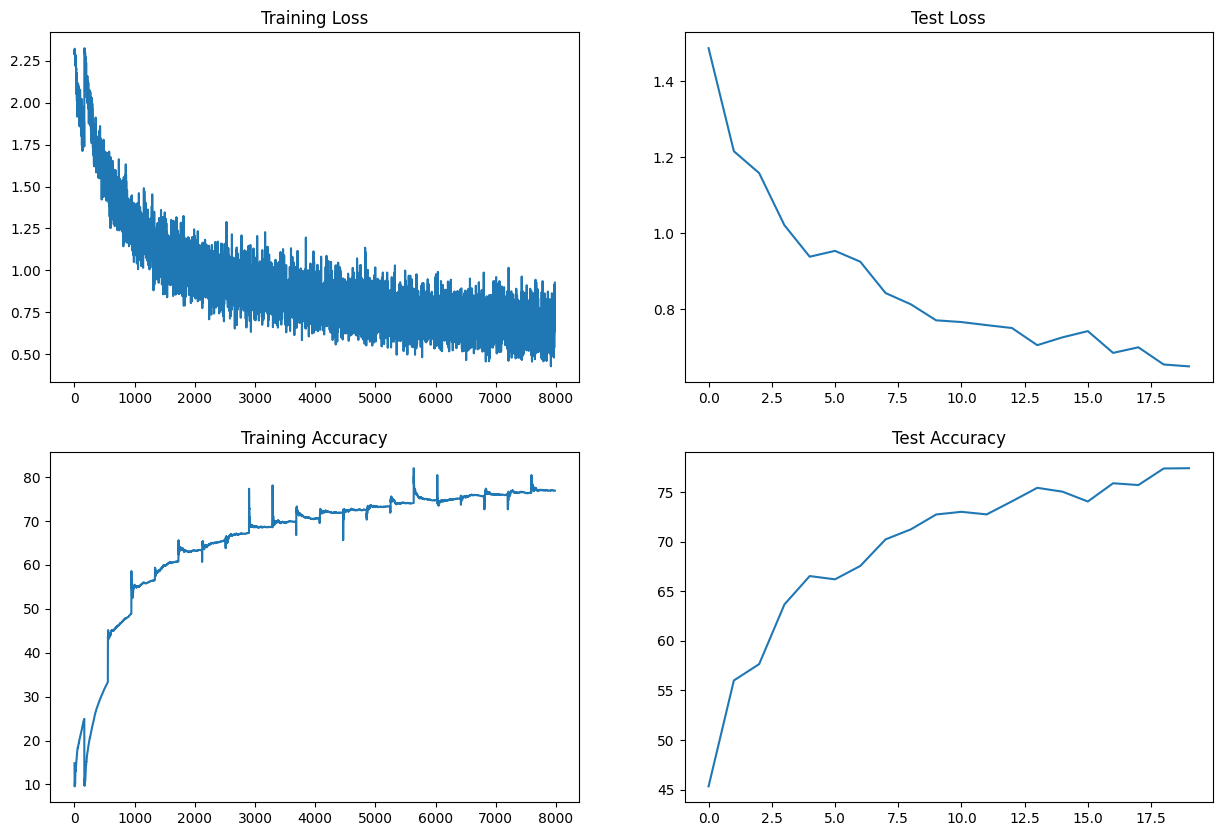

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

#Visualize the mis-classified Images

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


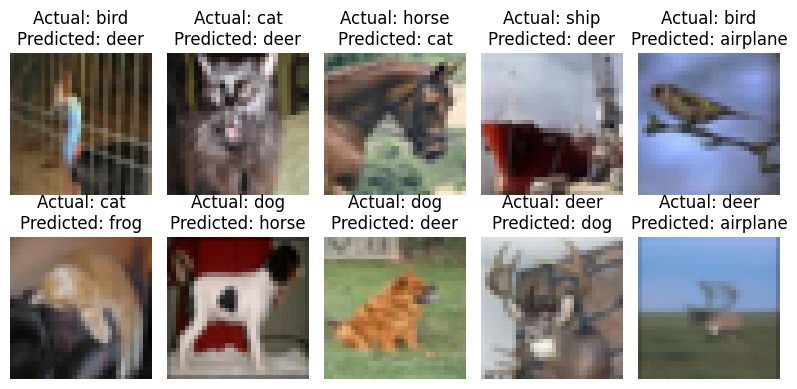

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the list of actual labels
y_test = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def show_misclassified_images(net, dataloader, device):
    net.eval()
    with torch.no_grad():
        misclassified_count = 0
        fig, axs = plt.subplots(2, 5, figsize=(8, 4))
        for batch in dataloader:
            inputs, labels = batch
            inputs = inputs.to(device, non_blocking=True)
            outputs = net(inputs)
            predictions = torch.argmax(outputs, dim=1)

            for sample_no in range(batch[0].shape[0]):
                if labels[sample_no] != predictions[sample_no]:
                    actual_label = y_test[labels[sample_no]]  # Get the actual label
                    predicted_label = y_test[predictions[sample_no]]  # Get the predicted label
                    image = inputs[sample_no].cpu().numpy().transpose(1, 2, 0)  # Convert to (H, W, C)
                    image = (image * 0.5) + 0.5  # Normalize pixel values

                    row_idx = misclassified_count // 5
                    col_idx = misclassified_count % 5
                    #axs[row_idx, col_idx].imshow(image.squeeze())
                    axs[row_idx % 2, col_idx].imshow(image.squeeze())
                    axs[row_idx % 2, col_idx].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
                    axs[row_idx % 2, col_idx].axis('off')
                    misclassified_count += 1
                    if misclassified_count >= 10:  # Display only 10 misclassified images
                        break

        plt.tight_layout()
        plt.show()

# Call the function with appropriate arguments (model, test_loader, device)
show_misclassified_images(model, test_loader, device)